In [3]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

from auxiliary import get_treatment_probability
from auxiliary import get_plot_probability
from auxiliary import plot_outcomes

# Regression discontinuity design

This following material is mostly based on the following review:

* Lee, D. S., and Lemieux, T. (2010). [Regression discontinuity designs in economics](https://www.aeaweb.org/articles?id=10.1257/jel.48.2.281). *Journal of Economic Literature, 48*(2), 281–355.

The idea of the authors is to throughout contrast RDD to its alternatives. They initially just mention selected features throughout the introduction but then also devote a whole section to it. This clearly is a core strength of the article. I hope to maintain this focus in my lecture. Also, their main selling point for RDD as the close cousin to standard randomized controlled trial is that the behavioral assumption of imprecise control about the assignment variable translates
into the statistical assumptions of a randomized experiment.

**Original application**

In the initial application of RD designs, Thistlethwaite & Campell (1960) analyzed the impact of merit rewards on future academic outcomes. The awards were allocated based on the observed test score. The main idea behind the research design was that individuals with scores just below the cutoff (who did not get the award) were good comparisons to those just above the cutoff (who did receive the award).


**Causal graph**

<img src="material/fig-rdd-setup.png" width="500">



## Intuition

**Key points of RD design**

- RD designs can be invalid if individuals can precisely manipulate the assignment variable - discontinuity rules might generate incentives

- If individuals - even while having some influence - are unable to precisely manipulate the assignment variable, a consequence of this is that the variation in treatment near the threshold is randomized as though from a randomized experiment - contrast to IV assumption

- RD designs can be analyzed - and tested - like randomized experiments.

- Graphical representation of an RD design is helpful and informative, but the visual presentation should not be tilted toward either finding an effect or finding no effect.

- Nonparametric estimation does not represent a "solution" to functional form issues raised by RD designs. It is therefore helpful to view it as a complement to - rather than a substitute for - parametric estimation.

- Goodness-of-fit and other statistical tests can help rule out overly restrictive specifications.

**Baseline**

A simple way to estimating the treatment effect $\tau$ is to run the following linear regression.

\begin{align*}
Y = \alpha + D \tau + X \beta + \epsilon,
\end{align*}

where $D \in [0, 1]$ and we have $D = 1$ if $X \geq c$ and $D=0$ otherwise.

**Baseline setup**

<img src="material/fig-1.png" width="500">

* "all other factors" determining $Y$ must be evolving "smoothly" (continously) with respect to $X$.

* the estimate will depend on the functional form

**Potential outcome framework**

<img src="material/fig-2.png" width="500">

**Potential outcome framework**


Suppose $D = 1$ if $X \geq c$, and $D=0$ otherwise
\begin{align*}
\Rightarrow\begin{cases}
E(Y \mid X = c) = E(Y_0 \mid X = c) & \text{for}\quad X < c     \\
E(Y \mid X = c) = E(Y_1 \mid X = c) & \text{for}\quad X \geq c
\end{cases}
\end{align*}

Suppose $E(Y_1\mid X = c), E(Y_0\mid X = c)$ are continuous in $x$.
\begin{align*}
\Rightarrow\begin{cases}
\lim_{\epsilon \searrow 0} E(Y_0\mid X = c - \epsilon) = E(Y_0\mid X = c) \\
\lim_{\epsilon \searrow 0} E(Y_1\mid X = c + \epsilon) = E(Y_1\mid X = c) \\
\end{cases}
\end{align*}

\begin{align*}
&\lim_{\epsilon \searrow 0} E(Y\mid X = c + \epsilon) - \lim_{\epsilon \searrow 0} E(Y\mid X = c - \epsilon) \\
&\qquad= \lim_{\epsilon \searrow 0} E(Y_1\mid X = c + \epsilon) - \lim_{\epsilon \searrow 0}E(Y_0\mid X = c - \epsilon) \\
&\qquad=E(Y_1\mid X = c) - E(Y_0\mid X = c) \\
&\qquad=E(Y_1 - Y_0\mid X = c)
\end{align*}

$\Rightarrow$ average treatment effect at the cutoff

### Sharp and Fuzzy design

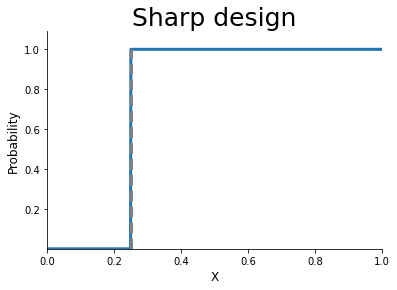

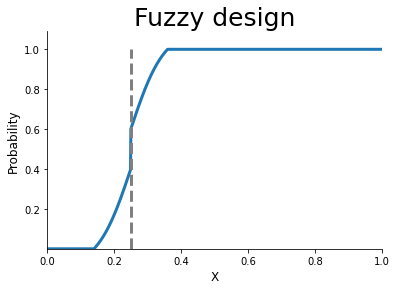

In [4]:
grid = np.linspace(0, 1.0, num=1000)
for version in ["sharp", "fuzzy"]:
    probs = get_treatment_probability(version, grid)
    get_plot_probability(version, grid, probs)

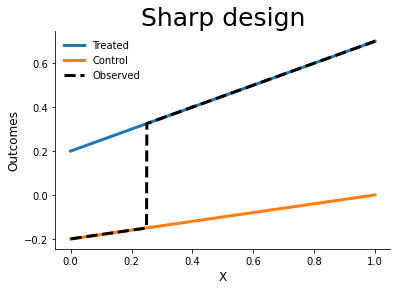

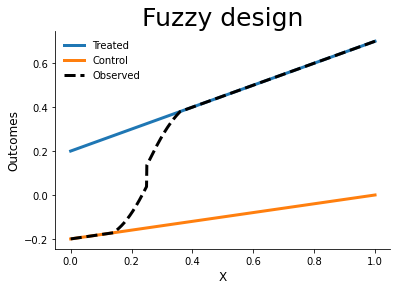

In [5]:
for version in ["sharp", "fuzzy"]:
    plot_outcomes(version, grid)

**Alternatives**

Consider the standard assumptions for matching:

- ignorability - trivially satisfied by research design as there is no variation left in $D$ conditional on $X$
- common support - cannot be satisfied and replaced by continuity

Lee and Lemieux (2010) emphasize the close connection of RDD to randomized experiments.
- How does the graph in the potential outcome framework change?

<img src="material/fig-3.png" width="500">

Continuity, the key assumption of RDD, is a consequence of the research design (e.g. randomization) and not simply imposed.

## Identification

Ad-hoc $\times$ vs. thoughtful answers $\checkmark$. Both are true, but only thoughtful consideration clarifies the strength of the regression discontinuity design as opposed to, for example, an instrumental variables approach.

**Question**

How do I know whether an RD design is appropriate for my context? When are the identification assumptions plausable or implausable?

**Answers**

$\times$ An RD design will be appropriate if it is plausible that all other unobservable factors are "continuously"  related to the assignment variable.

$\checkmark$ When there is a continuously distributed stochastic error component to the assignment variable - which can occur when optimizing agents do not have \textit{precise} control over the assignment variable - then the variation in the treatment will be as good as randomized in a neighborhood around the discontinuity threshold.

**Question**

Is there any way I can test those assumptions?

**Answers**

$\times$ No, the continuity assumption is necessary so there are no tests for the validity of the design.

$\checkmark$ Yes. As in randomized experiment, the distribution of observed baseline covariates should not change discontinuously around the threshold.

**Simplified setup**

\begin{align*}
Y & = D \tau + W \delta_1 + U \\
D & = I [X \geq c] \\
X & = W \delta_2 + V
\end{align*}

- $W$ is the vector of all predetermined and observable characteristics.

What are the source of heterogeneity in the outcome and assignment variable?

The setup for an RD design is more flexible than other estimation strategies.
- We allow for $W$ to be endogenously determined as long as it is determined prior to $V$. This ensures some random variation around the threshold.
- We take no stance as to whether some elements $\delta_1$ and $\delta_2$ are zero (exclusion restrictions)
- We make no assumptions about the correlations between $W$, $U$, and $V$.

<img src="material/fig-4.png" width="500">

**Local randomization**

We say individuals have imprecise control over $X$ when conditional on $W = w$ and $U = u$ the density of $V$ (and hence $X$) is continuous.

**Applying Baye's rule**

\begin{align*}
& \Pr[W = w, U = u \mid X = x] \\
&\qquad\qquad = f(x \mid W = w, U = u) \quad\frac{\Pr[W = w, U = u]}{f(x)}
\end{align*}

**Local randomization:** If individuals have imprecise control over $X$ as defined above, then $\Pr[W =w, U = u \mid X = x]$ is continuous in $x$: the treatment is "as good as" randomly assigned around the cutoff.

$\Rightarrow$ the behavioral assumption of imprecise control of $X$ around the threshold has the prediction that treatment is locally randmized.

**Consequences**

- testing prediction that $\Pr[W =w, U = u \mid X = x]$ is continuous in $X$ by at least looking at $\Pr[W =w\mid X = x]$
- irrelevance of including baseline covariates

## Interpretation

**Questions**

To what extent are results from RD designs generalizable?

**Answers**

$\times$ The RD estimate of the treatment effect is only applicable to the subpopulation of individuals at the discontinuity threshold and uninformative about the effect everywhere else.

$\checkmark$ The RD estimand can be interpreted as a weighted average treatment effect, where the weights are relative ex ante probability that the value of an individual's assignment variable will be in the neighborhood of the threshold.

## Alternative evaluation strategies

- randomized experiment
- regression discontinuity design
- matching on observables
- instrumental variables

How do the (assumed) relationships between treatment, observables, and unobservable differ across research designs?

**Endogenous dummy variable**

\begin{align*}
Y & = D \tau + W \delta_1 + U \\
D & = I[X \geq c] \\
X & = W \delta_2 + V
\end{align*}


<img src="material/fig-5-a.png" width="500">

* By construction $X$ is not related to any other observable or unoservable characteristic.

<img src="material/fig-5-b.png" width="500">

* $W$ and $D$ might be systematically related to $X$

<img src="material/fig-5-c.png" width="500">

* The crucial assumptions is that the two lines in the left graph are actually superimposed of each other.

* The plot in the middle is missing as all variables are used for estimation are not available to test the validity of identifying assumptions.

<img src="material/fig-5-d.png" width="500">

* The instrument must affect treatment probablity.
* A proper instructment requires the line in the right graph to be flat.

## Nonlinear expectation

A nonlinear conditional expectation can easily lead to misleading result if the estimated model is based on an local linear regression. The example below, including the simulation code, is adopted from Cunningham (2021). This example is set up closely aligned with the potential outcome framework. 

In [6]:
df = pd.DataFrame(columns=["Y", "Y1", "Y0", "X", "X2"], dtype=float)

# We simulate a running variable, truncate it at
# zero and restrict it below 240.
df["X"] = np.random.normal(100, 50, 1000)
df.loc[df["X"] < 0, "X"] = 0
df = df[df["X"] < 280]

df["X2"] = df["X"] ** 2

df["D"] = 0
df.loc[df["X"] > 140, "D"] = 1

We now simulate the potential outcomes and record the observed outcome. Note that there is no effect of treatment.

In [7]:
def get_outcomes(x, d):

    level = 10000 - 100 * x + x ** 2
    eps = np.random.normal(0, 1000, 2)
    y1, y0 = level + eps
    y = d * y1 + (1 - d) * y0

    return y, y1, y0


for idx, row in df.iterrows():
    df.loc[idx, ["Y", "Y1", "Y0"]] = get_outcomes(row["X"], row["D"])

df = df.astype(float)

What about the difference in average outcomes by treatment status. Where does the difference come from?

In [8]:
df.groupby("D")["Y"].mean()

D
0.0     9836.848389
1.0    21643.244614
Name: Y, dtype: float64

Now we are ready for a proper RDD setup.

In [9]:
for ext_ in ["X", "X + X2 "]:
    rslt = smf.ols(formula=f"Y ~ D + {ext_}", data=df).fit()
    print(rslt.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     1795.
Date:                Wed, 07 Jul 2021   Prob (F-statistic):               0.00
Time:                        08:59:13   Log-Likelihood:                -9407.4
No. Observations:                1000   AIC:                         1.882e+04
Df Residuals:                     997   BIC:                         1.884e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4377.3226    241.423     18.131      0.0

In a nutsheel, the misspecification of the model for the conditional mean functions results in flawed inference.

## Estimation

### Lee (2008)

The author studies the "incumbency advantage", i.e. the overall causal impact of being the current incumbent party in a district on the votes obtained in the district's election.

* Lee, David S. (2008). Randomized experiments from non-random selection in U.S. House elections. Journal of Econometrics.

In [13]:
df_base = pd.read_csv("../../datasets/processed/msc/house.csv")
df_base.head()

,vote_last,vote_next
0,0.1049,0.5810
1,0.1393,0.4611
2,-0.0736,0.5434
3,0.0868,0.5846
4,0.3994,0.5803


Let's put in some effort to ease the flow of our coming analysis.

In [9]:
df_base.rename(columns={"vote_last": "last", "vote_next": "next"}, inplace=True)

df_base["incumbent_last"] = np.where(df_base["last"] > 0.0, "democratic", "republican")
df_base["incumbent_next"] = np.where(df_base["next"] > 0.5, "democratic", "republican")

df_base["D"] = df_base["last"] > 0

for level in range(2, 5):
    label = "last_{:}".format(level)
    df_base.loc[:, label] = df_base["last"] ** level

The column `vote_last` refers to the Democrat's winning margin and is thus bounded between $-1$ and $1$. So a positive number indicates a Democrat as the incumbent.

### What are the basic characteristics of the dataset?

<AxesSubplot:xlabel='last', ylabel='next'>

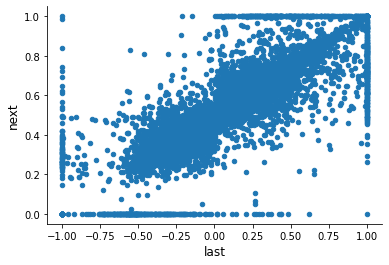

In [10]:
df_base.plot.scatter(x="last", y="next")

What is going on at the boundary? What is the re-election rate?

In [11]:
info = pd.crosstab(df_base["incumbent_last"], df_base["incumbent_next"], normalize=True)
stat = info.to_numpy().diagonal().sum() * 100
print(f"Re-election rate: {stat:5.2f}%")

Re-election rate: 90.93%


### Regression discontinuity design

How does the average vote in the next election look like as we move along last year's election.

<AxesSubplot:xlabel='last', ylabel='next'>

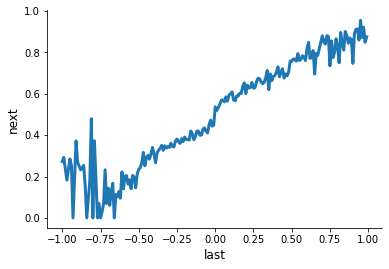

In [12]:
df_base["bin"] = pd.cut(df_base["last"], 200, labels=False) / 100 - 1
df_base.groupby("bin")["next"].mean().plot(xlabel="last", ylabel="next")

We can now compute the difference at the cutoffs to get an estimate for the treatment effect.

In [13]:
h = 0.05
df_subset = df_base[df_base["last"].between(-h, h)]
stat = np.abs(df_subset.groupby("incumbent_last")["next"].mean().diff()[1])
print(f"Treatment Effect: {stat:5.3f}")

Treatment Effect: 0.096


How does the effect depend on the size subset under consideration?

## Regression approach

Now we turn to an explicit model of the conditional mean. We first set up explicit models on both sides of the cutoff and then aggreagte the model into single regression estimations.

In [14]:
def fit_regression(incumbent, df, level=4):

    df_incumbent = df[df["incumbent_last"] == incumbent].copy()

    formula = "next ~ last"
    for level in range(2, level + 1):
        label = "last_{:}".format(level)
        formula += f" + {label}"

    rslt = smf.ols(formula=formula, data=df_incumbent).fit()
    return rslt


rslt = dict()
for incumbent in ["republican", "democratic"]:
    rslt = fit_regression(incumbent, df_base, level=3)
    title = "\n\n {:}\n".format(incumbent.capitalize())
    print(title, rslt.summary())



 Republican
                             OLS Regression Results                            
Dep. Variable:                   next   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     339.2
Date:                Wed, 30 Jun 2021   Prob (F-statistic):          3.05e-187
Time:                        12:05:34   Log-Likelihood:                 1749.4
No. Observations:                2740   AIC:                            -3491.
Df Residuals:                    2736   BIC:                            -3467.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4278      0.007     

How does the predictions look like?

In [15]:
dfs = list()

for incumbent in ["republican", "democratic"]:
    rslt = fit_regression(incumbent, df_base, level=4)

    # For our predictions, we need to set up a grid for the evaluation.
    if incumbent == "republican":
        grid = np.linspace(-0.5, 0.0, 51)
    else:
        grid = np.linspace(+0.0, 0.5, 51)

    df_grid = pd.DataFrame(grid, columns=["last"])

    for level in range(2, 5):
        label = "last_{:}".format(level)
        df_grid.loc[:, label] = df_grid["last"] ** level

    tmp = pd.DataFrame(rslt.predict(df_grid), columns=["prediction"])
    tmp.index = df_grid["last"]
    dfs.append(tmp)

rslts = pd.concat(dfs)

Let's have a look at the estimated conditional mean fuctions.

<AxesSubplot:xlabel='last'>

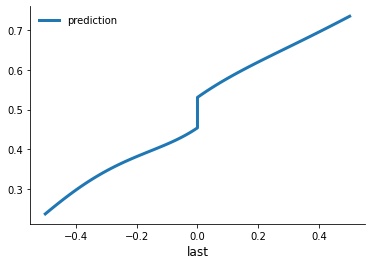

In [16]:
rslts.plot()

### Regression 

There are several alternatives to estimate the conditional mean functions.

* pooled regressions

* local linear regressions

#### Pooled regression

We estimate the conditinal mean using the whole function.

\begin{align*}
Y = \alpha + \tau D + \beta X + \epsilon
\end{align*}

This allows for a difference in levels but not slope.

In [17]:
smf.ols(formula="next ~ last + D", data=df_base).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   next   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     6658.
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        12:05:34   Log-Likelihood:                 3661.9
No. Observations:                6558   AIC:                            -7318.
Df Residuals:                    6555   BIC:                            -7298.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4427      0.003    139.745      0.000       0.437       0.449
D[T.True]      0.1137      0.006     20.572      0.000       0.103       0.125
last           0.3305      0.006     55.186      0.000       0.319       0.342
==============================================================================
Omnibus:                      595.910   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3444.243
Skew:                          -0.225   Prob(JB):                         0.00
Kurtosis:                       6.522   Cond. No.                         5.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Local linear regression

We now turn to local regressions by restricting the estimation to observations close to the cutoff.

\begin{align*}
Y = \alpha + \tau D + \beta X + \gamma X D + \epsilon,
\end{align*}

where $-h \geq X \geq h$. This allows for a difference in levels and slope.

In [18]:
for h in [0.3, 0.2, 0.1, 0.05, 0.01]:
    # We restrict the sample to observations close
    # to the cutoff.
    df = df_base[df_base["last"].between(-h, h)]

    formula = "next ~ D + last + D * last"
    rslt = smf.ols(formula=formula, data=df).fit()
    info = [h, rslt.params[1] * 100, rslt.pvalues[1]]
    print(" Bandwidth: {:>4}   Effect {:5.3f}%    pvalue {:5.3f}".format(*info))

 Bandwidth:  0.3   Effect 8.318%    pvalue 0.000
 Bandwidth:  0.2   Effect 7.818%    pvalue 0.000
 Bandwidth:  0.1   Effect 6.058%    pvalue 0.000
 Bandwidth: 0.05   Effect 4.870%    pvalue 0.010
 Bandwidth: 0.01   Effect 9.585%    pvalue 0.001


There exists some work that can guide the choice of the bandwidth. Now, let's summarize the key issues and some review best practices.

## Checklist

**Recommendations:**
- To assess the possibility of manipulations of the assignment variable, show its distribution.
- Present the main RD graph using binned local averages.
- Graph a benchmark polynomial specification
- Explore the sensitivity of the results to a range of bandwidth, and a range of orders to the polynomial.
- Conduct a parallel RD analysis on the baseline covariates.
- Explore the sensitivity of the results to the inclusion of baseline covariates.

## References
* **Hahn, J., Todd, P. E., and van der Klaauw, W. (2001)**. [Identification and estimation of treatment effects with a regression-discontinuity design](https://www.jstor.org/stable/2692190). *Econometrica*, 69(1), 201–209.


* **Lee, D. S. (2008)**. [Randomized experiments from nonrandom selection in US House elections](https://www.sciencedirect.com/science/article/abs/pii/S0304407607001121). *Journal of Econometrics*, 142(2), 675–697.


* **Lee, D. S., and Lemieux, T. (2010)**. [Regression discontinuity designs in economics](https://www.aeaweb.org/articles?id=10.1257/jel.48.2.281). *Journal of Economic Literature*, 48(2), 281–355.


* **Thistlethwaite, D. L., and Campbell, D. T. (1960)**. [Regression-discontinuity analysis: An alternative to the ex-post facto experiment](https://psycnet.apa.org/record/1962-00061-001). *Journal of Educational Psychology*, 51(6), 309–317.


* **Cunningham, S. (2021)**. [Causal Inference: The Mixtape](https://www.scunning.com/mixtape.html#:~:text=Causal%20Inference%3A%20The%20Mixtape.%20An%20accessible%2C%20contemporary%20introduction,allow%20social%20scientists%20to%20determine%20what%20causes%20what.). *Yale University Press*